In [1]:
from scipy.stats.distributions import chi2
from IPython import display

import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# a test of narray-based matrix multiplication
# a = np.array([[1, 1], [2, 2]])
# b = np.array([[3, 3], [4, 4]])
# print(a)
# print(b)
# print(a @ b)
# print(a @ b.T)

In [3]:
def EKFUpdate(x_hat_last, P_hat_last, y, A, Q, beacon, R):
    n = len(x_hat_last)
    m = len(y)
    
    # prediction
    x_hat_pred = A @ x_hat_last
    P_hat_pred = A @ P_hat_last @ A.T + Q

    # measurement update
    H = np.zeros([m, n])
    for i in range(m):
        for j in range(2):
            dem = math.sqrt(math.pow((x_hat_pred[0] - beacon[0, i]), 2) + math.pow((x_hat_pred[1] - beacon[1, i]), 2))
            H[i, j] = (x_hat_pred[j] - beacon[j, i]) / dem

    K = P_hat_pred @ H.T @ np.linalg.inv(H @ P_hat_pred @ H.T + R)
    h_no_noise = np.zeros([m])
    for i in range(m):
        h_no_noise[i] = np.linalg.norm(x_hat_pred[0 : 2] - beacon[:, i])
    x_hat_curr = x_hat_pred + K @ (y - h_no_noise)
    P_hat_curr = (np.identity(n) - K @ H) @ P_hat_pred

    return x_hat_curr, P_hat_curr

In [4]:
#  plot cL-confidence ellipsoid for 2D Gaussian random vector with mean and covariance matrix
def ConfEllipse(mean, covariance, confidence_level):
    # for eigen_vectors, each column is a feature vector
    eigen_values, eigen_vectors = np.linalg.eig(covariance)
    idx = eigen_values.argsort()[::-1]   
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]

    chi2_value = chi2.ppf(confidence_level, df = 2)
    semi_major_axis = np.sqrt(chi2_value * eigen_values[0])
    semi_minor_axis = np.sqrt(chi2_value * eigen_values[1])

    theta = np.linspace(0, 2 * math.pi, 628)

    standard_ellipse_x = semi_major_axis * np.cos(theta)
    standard_ellipse_y = semi_minor_axis * np.sin(theta)

    ellipse_xy = eigen_vectors @ np.array([standard_ellipse_x, standard_ellipse_y])
    ellipse_x = ellipse_xy[0, :] + mean[0]
    ellipse_y = ellipse_xy[1, :] + mean[1]

    # rotation_angle = np.arctan2(eigen_vectors[1, 0], eigen_vectors[0, 0])
    
    # theta = np.linspace(0, 2 * math.pi, 628)
    # ellipse_x_1 = mean[0] + semi_major_axis * np.cos(theta) * np.cos(rotation_angle) - semi_minor_axis * np.sin(theta) * np.sin(rotation_angle)
    # ellipse_y_1 = mean[1] + semi_major_axis * np.cos(theta) * np.sin(rotation_angle) + semi_minor_axis * np.sin(theta) * np.cos(rotation_angle)

    return ellipse_x, ellipse_y

In [5]:
def multi(multi, arr):

    arr_multi = np.zeros(len(arr))
    for i in range(len(arr)):
        arr_multi[i] = multi * arr[i]
    
    return arr_multi


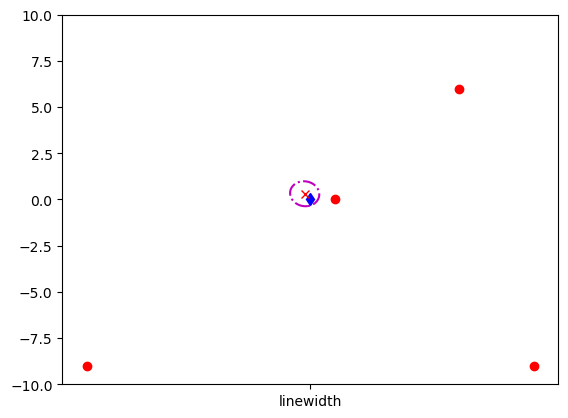

In [6]:
beacon = np.array([[-9, 1, 9, 6], [-9, 0, -9, 6]])
# pose = np.zeros(2)
pose = np.array([-8, 8])

t_delta = 0.1
# v = np.array([1.0, 1.0])
v = np.array([1.0, -1.0])

# x_ini = np.append(pose, v)
# x_ini = np.array([0.0, 0.0, 0.0, 0.0])
x_ini = np.array([-8, 8, 0.0, 0.0])
P_ini = np.identity(4)


n = np.size(x_ini)
m = np.size(beacon[0, :])
A = np.array([[1, 0, t_delta, 0], [0, 1, 0, t_delta], [0, 0, 1, 0], [0, 0, 0, 1]])
noise_var_state = 0.1
noise_var_meas = 0.2
Q = noise_var_state * np.identity(n)
R = noise_var_meas * np.identity(m)

x_hat = x_ini
P_hat = P_ini

plt.ion()
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10))

for i in range(80):
    y = np.zeros(m)
    for j in range(m):
        y[j] = np.linalg.norm(pose - beacon[:, j]) + math.sqrt(noise_var_meas) * np.random.randn(1)[0]
    pose = pose + multi(t_delta, v)
    x_hat, P_hat = EKFUpdate(x_hat, P_hat, y, A, Q, beacon, R)
    ellipse_x, ellipse_y = ConfEllipse(x_hat[0 : 2], P_hat[0 : 2, 0 : 2], 0.95)

    plt.cla()
    plt.xlim((-10, 10))
    plt.ylim((-10, 10))
    plt.plot(beacon[0, :], beacon[1, :] ,'ro')
    plt.plot(pose[0], pose[1],'bd')
    plt.plot(x_hat[0], x_hat[1], 'rx')
    plt.plot(ellipse_x, ellipse_y, 'm-.', 'linewidth', 2)
    display.clear_output(wait = True)
    plt.pause(0.1) 

plt.show()



